# Regression Techniques 
#### This notebook demonstrates various regression techniques using real-world datasets


---

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant
from sklearn.linear_model import LinearRegression


### Exploratory Data Analysis (EDA) for Auto MPG Dataset

We will explore the dataset to check for distributions, correlations, and assumptions like multicollinearity, linearity, and normality of residuals.



In [ ]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", 'car_name']
df = pd.read_csv(url, delim_whitespace=True, names=columns, na_values="?")

# Drop missing values
df.dropna(inplace=True)

# Convert horsepower to numeric
df["horsepower"] = df["horsepower"].astype(float)

# Add some irrelevant features (random noise)
df["random_noise_1"] = np.random.normal(size=len(df))
df["random_noise_2"] = np.random.uniform(0, 1, size=len(df))

# Display first few rows
print(df.head())

# Summary statistics
print(df.describe())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


<ipython-input-2-95e7a27d8e59>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, names=columns, na_values="?")


    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  random_noise_1  \
0          70       1  chevrolet chevelle malibu       -0.145539   
1          70       1          buick skylark 320       -0.570579   
2          70       1         plymouth satellite        0.682660   
3          70       1              amc rebel sst        0.584396   
4          70       1                ford torino        0.165032   

   random_noise_2  
0        0.850412  
1        0.171111  
2        0.420396  
3        0.779304  
4        0.493992  
              mpg   cylinders  displacement  horse

### Visualizing Feature Distributions

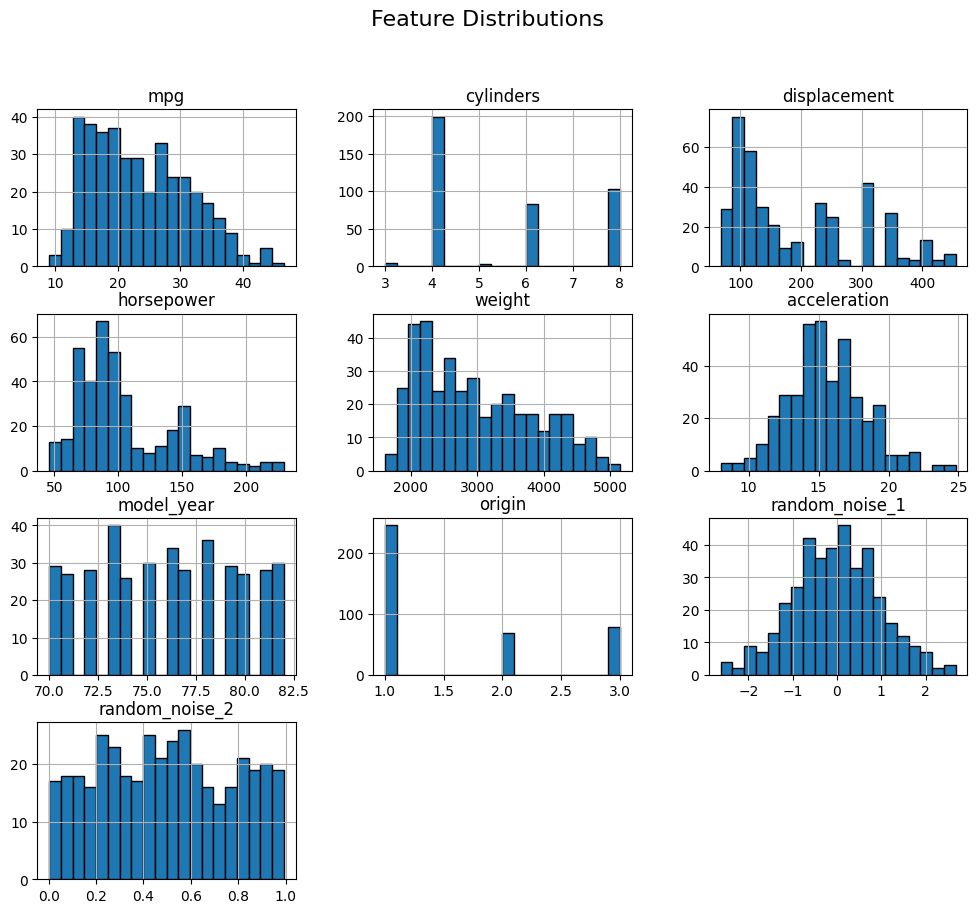

In [ ]:
# Histogram of all features
df.hist(figsize=(12, 10), bins=20, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

**Reflection Questions**
- Are features normally distributed?

 - Some features may be normally distributed, but others might show skewness. A histogram or Q-Q plot can confirm this.



- Are any variables skewed?
  - Yes, some variables likely exhibit skewness, which can be checked using skewness measures or visualized through histograms.


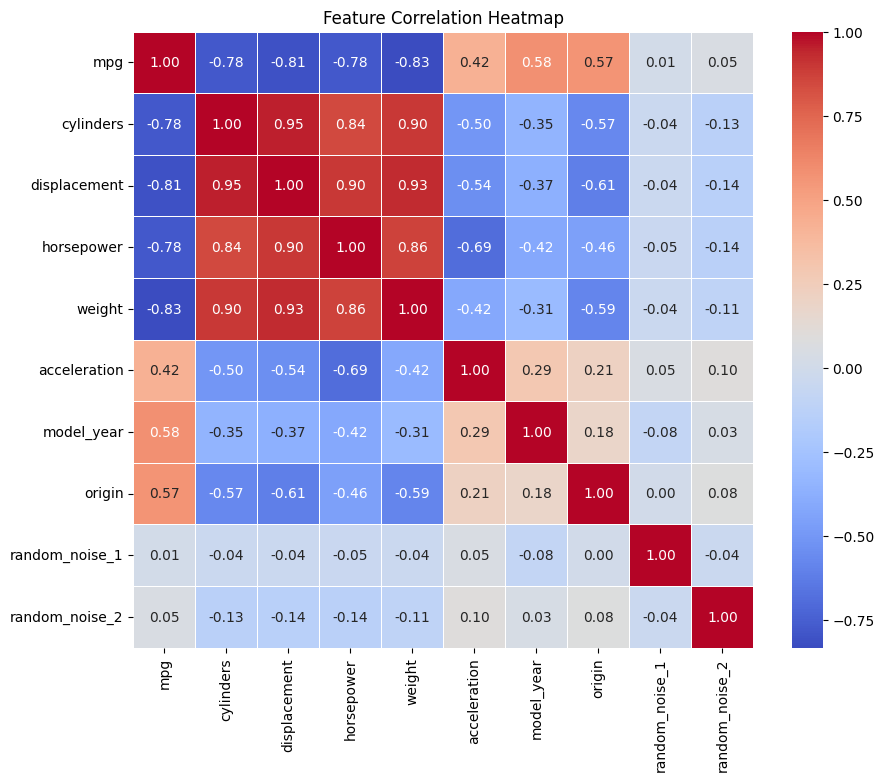

In [ ]:
# Convert 'origin' column to numeric if it contains numerical data but has object type
df['origin'] = pd.to_numeric(df['origin'], errors='coerce')  # 'coerce' will replace non-numeric values with NaN


plt.figure(figsize=(10, 8))
# Calculate correlation only for numeric columns, EXCLUDING the car name column
num_df = df.select_dtypes(include=np.number).drop(columns=['car_name'], errors='ignore')  # Select only numeric columns, ignore if 'car_name' doesn't exist
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

**Reflection Questions**

- Which features are strongly related to mpg?
  - Features like horsepower, weight, and displacement often have strong correlations with mpg.


- Identify irrelevant (random noise) features, which should have low correlations.
   - Features with near-zero correlation to mpg, such as non-numeric identifiers or redundant variables, may be considered irrelevant.



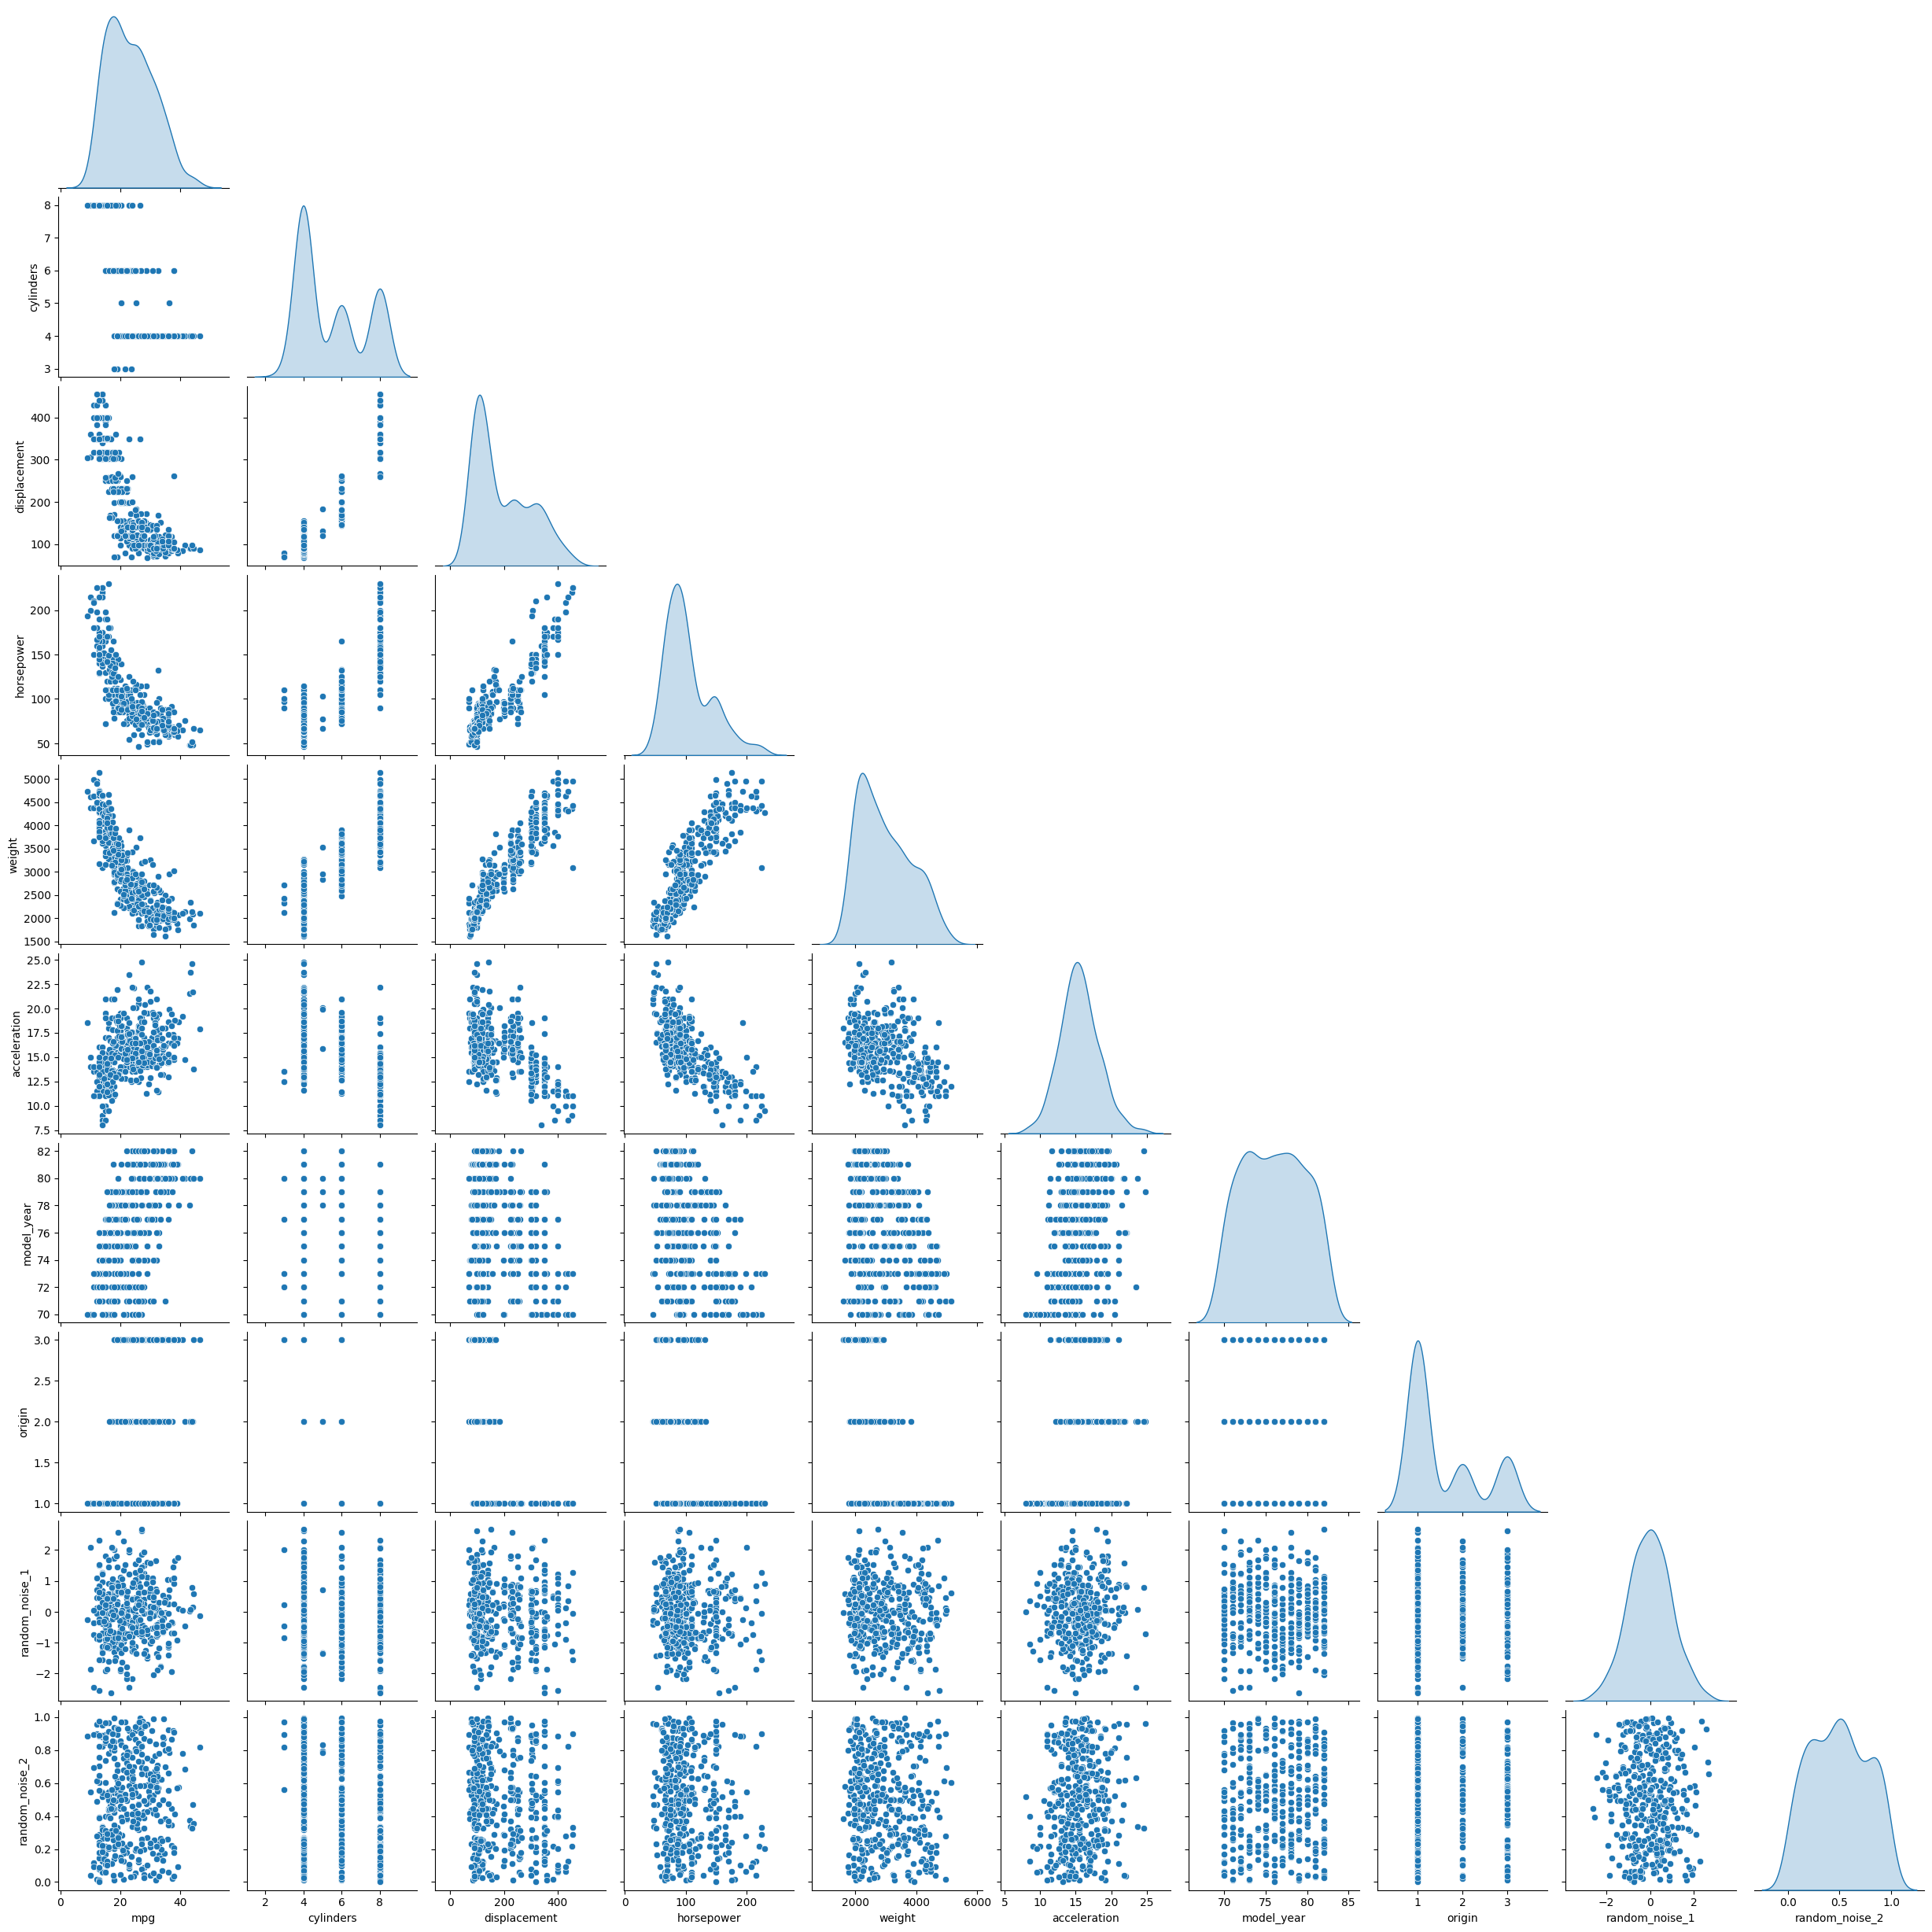

In [ ]:
sns.pairplot(df, diag_kind="kde", markers="o", corner=True)
plt.show()

## Checking Assumptions

### Multicollinearity Check Using Variance Inflation Factor (VIF)

In [ ]:
# Prepare data for VIF calculation
X = add_constant(df.drop(columns=["mpg"]))  # Include intercept
# Ensure all columns in X are numeric
X = X.select_dtypes(include=np.number) # Select only numeric columns
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif)


Variance Inflation Factor (VIF):
          Variable         VIF
0           const  780.089190
1       cylinders   10.739272
2    displacement   21.953482
3      horsepower    9.966415
4          weight   10.906505
5    acceleration    2.628367
6      model_year    1.263397
7          origin    1.773240
8  random_noise_1    1.019334
9  random_noise_2    1.032053


### Linearity & Residual Assumptions

Here we are fitting a linear regression model and observing patterns in the residuals produced.

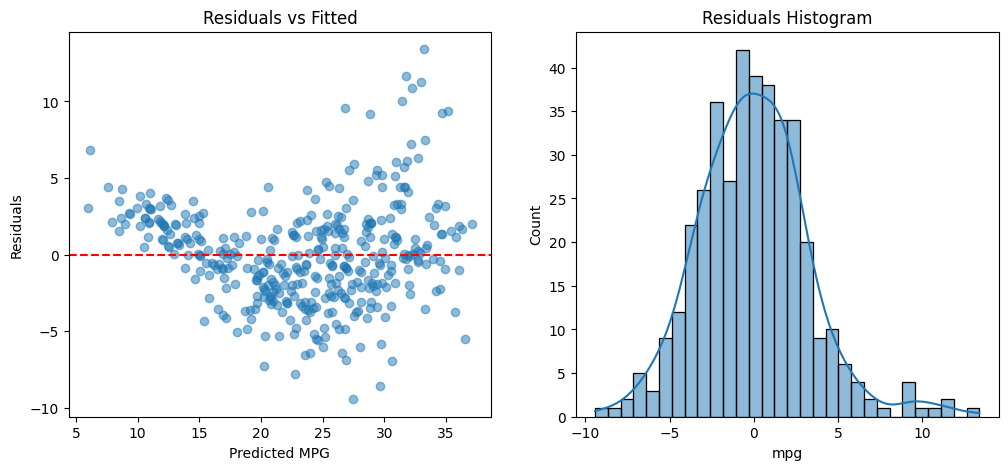

In [ ]:
# Define features and target
X = df.drop(columns=["mpg", "car_name"])  # Drop the 'car_name' column
y = df["mpg"]

# Fit linear model
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

# Compute residuals
residuals = y - y_pred

# Residuals vs. Fitted Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Predictions
ax[0].scatter(y_pred, residuals, alpha=0.5)
ax[0].axhline(y=0, color="red", linestyle="--")
ax[0].set_xlabel("Predicted MPG")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residuals vs Fitted")

# Residuals Distribution
sns.histplot(residuals, bins=30, kde=True, ax=ax[1])
ax[1].set_title("Residuals Histogram")

plt.show()

### *Key Takeaways from EDA*

1. Are the relationships between MPG and other variables linear? Something else?
2. Multicollinearity? Check heatmap + VIF.
3. Linearity assumptions? Check residual plot.
4. Normality? Check histogram.
5. Do we need regularization like Ridge? If VIF is high and coefficients are unstable, yes!

1. Started with Linear Regression & Check Residuals
- We found non-linearity & heteroskedasticity (suggesting polynomial terms are needed).

2. Next, Iterate Polynomial Degrees with Cross-Validation
- Use R² and RMSE to pick the best polynomial degree.

3. Then, Apply Ridge Regularization to the Best Polynomial Model
- Helps reduce overfitting from polynomial terms (remember high VIF values).

4. Apply Lasso Regression to Identify & Remove Irrelevant Features
- Removes random noise features by setting coefficients to zero.

5. Evaluate Model Performance & Interpret Feature Importance
- Compare linear vs. polynomial vs. ridge vs. lasso.
- Which model is most stable & interpretable?

---

## **Polynomial Regression with Cross-Validation**

### **Iterate Over Polynomial Degrees with Cross-Validation**

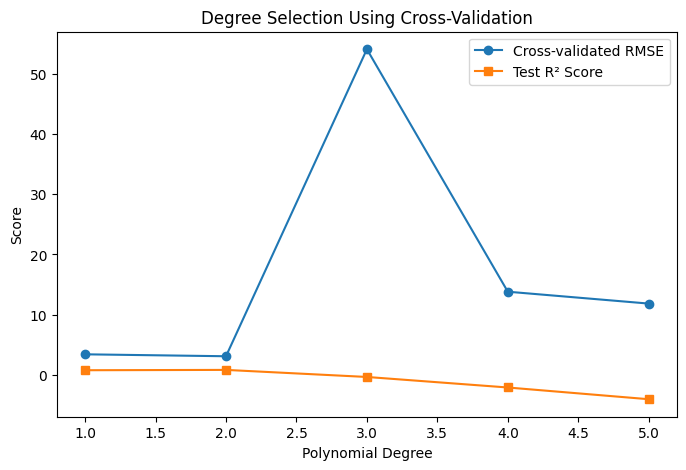

Best Polynomial Degree: 2


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define features and target
X = df.drop(columns=["mpg", "car_name"])  # Drop categorical 'car_name'
y = df["mpg"]

# Step 2: Split into training and testing sets BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale the training set (Fit on training data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Learn mean & std from training data
X_test_scaled = scaler.transform(X_test)  # Transform test data using training mean & std

# Step 4: Define polynomial degrees to test
degrees = range(1, 6)  # Test degrees 1 to 5
rmse_scores = []
r2_scores = []

# Step 5: Iterate through polynomial degrees
for degree in degrees:
    # Create a pipeline with polynomial transformation and linear regression
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())

    # Perform 5-fold cross-validation on training data
    scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)

    # Compute RMSE and R²
    rmse = np.mean(np.sqrt(-scores))
    model.fit(X_train_scaled, y_train)
    r2 = model.score(X_test_scaled, y_test)

    # Store results
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Step 6: Plot validation curve
plt.figure(figsize=(8,5))
plt.plot(degrees, rmse_scores, marker='o', label="Cross-validated RMSE")
plt.plot(degrees, r2_scores, marker='s', label="Test R² Score")
plt.xlabel("Polynomial Degree")
plt.ylabel("Score")
plt.title("Degree Selection Using Cross-Validation")
plt.legend()
plt.show()

# Step 7: Select the best polynomial degree (smallest RMSE)
best_degree = degrees[np.argmin(rmse_scores)]
print(f"Best Polynomial Degree: {best_degree}")

## **Apply Ridge Regularization**

Here, we will use the best polynomial degree found above


In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Create final polynomial transformer with best degree
poly = PolynomialFeatures(best_degree, include_bias=False)

# Transform training and testing data
X_train_poly_scaled = poly.fit_transform(X_train_scaled)
X_test_poly_scaled = poly.transform(X_test_scaled)

### Apply Ridge Regularization ###
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_poly_scaled, y_train)

# Predictions & Evaluation
y_ridge_pred = ridge.predict(X_test_poly_scaled)
ridge_r2 = ridge.score(X_test_poly_scaled, y_test)

print(f"Ridge Polynomial Regression R²: {ridge_r2:.4f}")
print(f"Best Ridge Alpha: {ridge.alpha_:.4f}")


Ridge Polynomial Regression R²: 0.8745
Best Ridge Alpha: 8.6975


## **Apply Lasso Regression to Remove Irrelevant Features**

In [ ]:
lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=50000)
lasso.fit(X_train_poly_scaled, y_train)

# Predictions & Evaluation
y_lasso_pred = lasso.predict(X_test_poly_scaled)
lasso_r2 = lasso.score(X_test_poly_scaled, y_test)

print(f"Lasso Polynomial Regression R²: {lasso_r2:.4f}")
print(f"Best Lasso Alpha: {lasso.alpha_:.4f}")

# Identify features removed by Lasso
lasso_coefs = pd.Series(lasso.coef_, index=poly.get_feature_names_out(X_train.columns))
removed_features = lasso_coefs[lasso_coefs == 0].index.tolist()

print(f"Features Removed by Lasso: {removed_features}")

Lasso Polynomial Regression R²: 0.8757
Best Lasso Alpha: 0.1520
Features Removed by Lasso: ['cylinders', 'acceleration', 'random_noise_1', 'random_noise_2', 'cylinders^2', 'cylinders displacement', 'cylinders horsepower', 'cylinders weight', 'cylinders acceleration', 'cylinders model_year', 'cylinders origin', 'cylinders random_noise_1', 'cylinders random_noise_2', 'displacement^2', 'displacement horsepower', 'displacement acceleration', 'displacement model_year', 'displacement origin', 'displacement random_noise_1', 'displacement random_noise_2', 'horsepower acceleration', 'horsepower origin', 'horsepower random_noise_1', 'horsepower random_noise_2', 'weight acceleration', 'weight model_year', 'weight origin', 'weight random_noise_1', 'weight random_noise_2', 'acceleration random_noise_1', 'acceleration random_noise_2', 'model_year origin', 'model_year random_noise_1', 'origin^2', 'origin random_noise_1', 'random_noise_1 random_noise_2']


## **Compare Model Performance**

Linear Regression R²: 0.7956
Linear Regression RMSE: 3.2298

🔎 Model Comparison:

                   Model  R² Score      RMSE
0      Linear Regression  0.795622  3.229798
1  Polynomial Regression  0.849980  3.114110
2       Ridge Regression  0.874534  2.530588
3       Lasso Regression  0.875699  2.518813


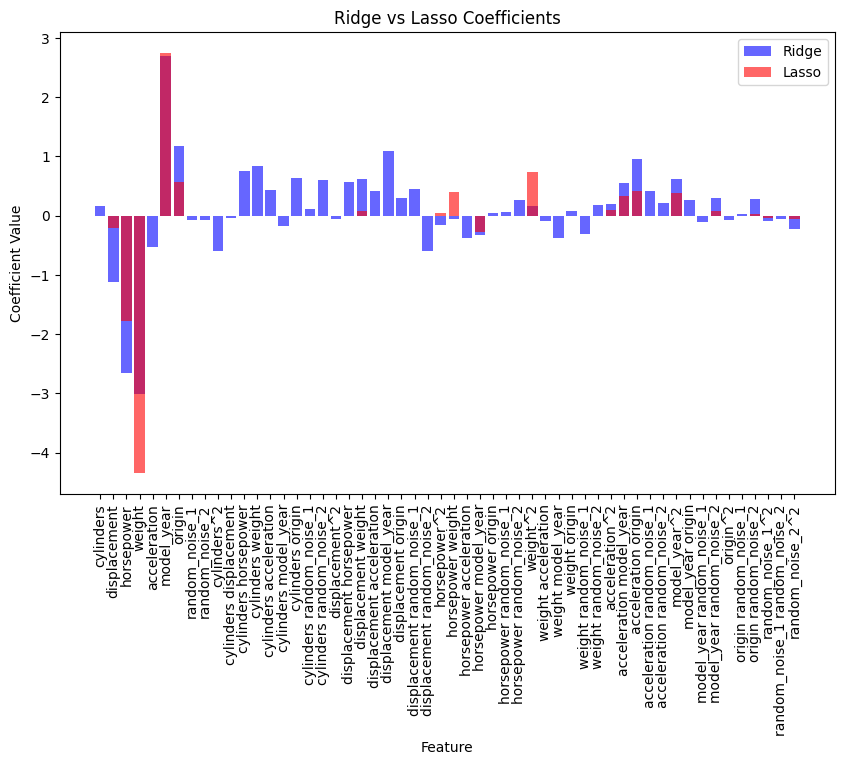

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Train a Basic Linear Regression Model ###
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)  # Fit to scaled features (no polynomial terms)

# Predictions
y_lin_pred = lin_reg.predict(X_test_scaled)

# Compute R² and RMSE for Linear Regression
lin_r2 = lin_reg.score(X_test_scaled, y_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_lin_pred))

print(f"Linear Regression R²: {lin_r2:.4f}")
print(f"Linear Regression RMSE: {lin_rmse:.4f}")

### Step 2: Compute RMSE for Other Models ###
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_ridge_pred))
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_lasso_pred))

### Step 3: Create Comparison Table ###
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Polynomial Regression", "Ridge Regression", "Lasso Regression"],
    "R² Score": [lin_r2, r2_scores[np.argmin(rmse_scores)], ridge_r2, lasso_r2],
    "RMSE": [lin_rmse, rmse_scores[np.argmin(rmse_scores)], ridge_rmse, lasso_rmse]
})

print("\n🔎 Model Comparison:\n")
print(comparison_df)

### Step 4: Visualize Ridge vs. Lasso Coefficient Shrinkage ###
ridge_coefs = pd.Series(ridge.coef_, index=poly.get_feature_names_out(X_train.columns))
lasso_coefs = pd.Series(lasso.coef_, index=poly.get_feature_names_out(X_train.columns))

plt.figure(figsize=(10,6))
plt.bar(ridge_coefs.index, ridge_coefs.values, color='blue', alpha=0.6, label="Ridge")
plt.bar(lasso_coefs.index, lasso_coefs.values, color='red', alpha=0.6, label="Lasso")
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.title("Ridge vs Lasso Coefficients")
plt.legend()
plt.show()

## Caveats & Considerations in Applying Regularization

While this notebook effectively demonstrates when and why we apply regularization, there are a few important considerations in real-world applications.

⸻

**1. Are There All Together Too Many Features?**
- In this notebook, we greatly expand the feature set using PolynomialFeatures(degree=2).
- While this helps capture nonlinear relationships, it explodes the number of features.

Potential Issue:
- If we start with 10 features, a degree-2 expansion generates ~55 features.
- This may lead to overfitting and make interpretation difficult.

Practical Consideration:
- Instead of adding all polynomial features, we may want to hand-select relevant interactions.

⸻

**2. Regularization vs. Feature Engineering**
- Lasso helps with feature selection, but ideally, we should carefully choose features beforehand.

Best Practice:
- Start with domain knowledge to identify meaningful interactions.
- Use exploratory analysis (e.g., correlation heatmaps) instead of blindly adding polynomial terms.

⸻

**3. High Correlation? PCA Might Be Better**
- When variables are highly correlated, polynomial expansion exacerbates multicollinearity.

Principal Component Analysis (PCA) can be an alternative:
- Instead of expanding features, PCA reduces dimensionality by finding new uncorrelated features.
- This can simplify the model while still capturing important variance in the data.

When to Use PCA Instead of Regularization:
- If correlation between features is very high → PCA can simplify the problem before modeling.
- If the dataset is large with redundant features → PCA reduces complexity.

## **A More Refined Approach:**

In the following code we first select hte three polynomial potential predictors of MPG, then scale, then apply PCA (as they are strongly correlated), then apply degree 2 polynomial regression.

✅ Polynomial Regression (With PCA) R² Score: 0.6752


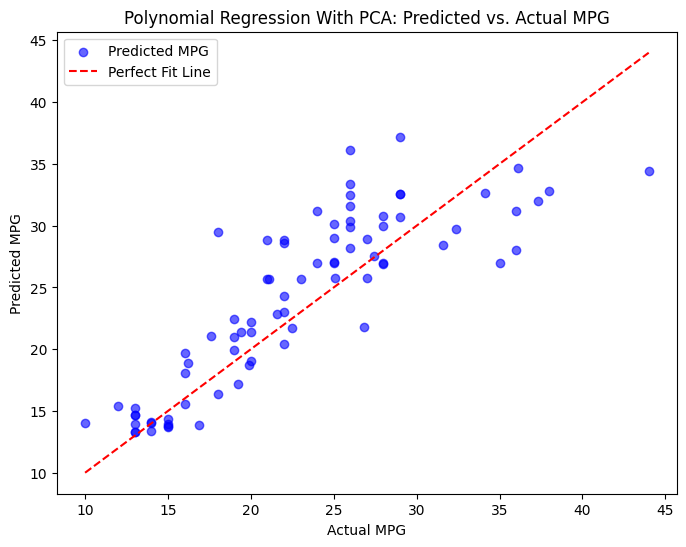

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Select the Three Polynomial Predictors
selected_features = ["displacement", "horsepower", "weight"]
X = df[selected_features]  # Feature matrix
y = df["mpg"]  # Target variable

# Step 2: Split into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Standardize Features (Important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Apply PCA (Reduce Correlation)
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 5: Generate Polynomial Features (Degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.transform(X_test_pca)

# Step 6: Fit Polynomial Regression Model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Step 7: Make Predictions and Evaluate Model
y_pred = poly_reg.predict(X_test_poly)
r2_score = poly_reg.score(X_test_poly, y_test)

print(f"✅ Polynomial Regression (With PCA) R² Score: {r2_score:.4f}")

# 🔹 Step 8: Visualize Fit vs. True MPG
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color="blue", alpha=0.6, label="Predicted MPG")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="dashed", label="Perfect Fit Line")
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Polynomial Regression With PCA: Predicted vs. Actual MPG")
plt.legend()
plt.show()

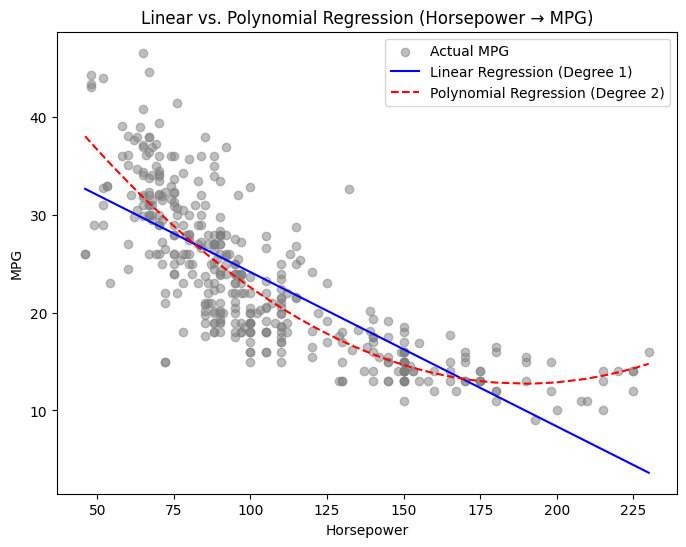

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Extract horsepower and mpg from the dataset
X_hp = df[['horsepower']].values  # Independent variable (needs 2D shape)
y_mpg = df['mpg'].values  # Dependent variable

# Sort values for plotting
sort_idx = np.argsort(X_hp[:, 0])
X_hp = X_hp[sort_idx]
y_mpg = y_mpg[sort_idx]

### 🚀 Step 1: Fit a Linear Regression Model ###
lin_reg = LinearRegression()
lin_reg.fit(X_hp, y_mpg)
y_lin_pred = lin_reg.predict(X_hp)

### 🚀 Step 2: Fit a Polynomial Regression Model (Degree 2) ###
poly = PolynomialFeatures(degree=2, include_bias=False)
X_hp_poly = poly.fit_transform(X_hp)  # Transform horsepower into polynomial features

poly_reg = LinearRegression()
poly_reg.fit(X_hp_poly, y_mpg)
y_poly_pred = poly_reg.predict(X_hp_poly)

### 🚀 Step 3: Plot the Linear vs. Polynomial Fits ###
plt.figure(figsize=(8,6))

# Scatter plot of raw data
plt.scatter(X_hp, y_mpg, color='gray', alpha=0.5, label="Actual MPG")

# Plot Linear Fit
plt.plot(X_hp, y_lin_pred, color='blue', label="Linear Regression (Degree 1)")

# Plot Polynomial Fit
plt.plot(X_hp, y_poly_pred, color='red', linestyle='dashed', label="Polynomial Regression (Degree 2)")

# Labels and Title
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Linear vs. Polynomial Regression (Horsepower → MPG)")
plt.legend()
plt.show()